# CASA0002 Assignment 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kstest, poisson, pearsonr
from math import sqrt

In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

## Part 1

In [3]:
# read the file
G = nx.read_graphml("london.graph")

In [4]:
# remove Battersea Power station
G.remove_node("Battersea Power Station")
G.remove_node("Nine Elms")
G.remove_node("Battersea Park")

In [5]:
print(nx.info(G))

Graph with 398 nodes and 464 edges


/tmp/ipykernel_726/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [6]:
# To check node attributes:
list(G.nodes(data = True))[0]

("Earl's Court", {'coords': '(525466.7699525921, 178494.18714144814)'})

In [7]:
# To check edge attributes:
list(G.edges(data = True))[0]

("Earl's Court",
 'Gloucester Road',
 {'length': 910.1212138490863, 'line_name': 'District', 'flows': 83187})

### Section I
#### Question I.1

In [8]:
### Degree centrality

# We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:15]

,degree
Stratford,0.022670
Bank and Monument,0.020151
Baker Street,0.017632
King's Cross St. Pancras,0.017632
Green Park,0.015113
Canning Town,0.015113
Waterloo,0.015113
West Ham,0.015113
Oxford Circus,0.015113
Liverpool Street,0.015113


In [9]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_sorted = df.sort_values(["betweenness_t"], ascending=False)
df_sorted[0:10]

,betweenness_t
Stratford,23570.593434
Bank and Monument,22790.325613
Liverpool Street,21386.387049
King's Cross St. Pancras,20275.771465
Waterloo,18723.082323
Green Park,16903.766558
Euston,16511.969913
Westminster,15870.455916
Baker Street,15145.718723
Finchley Road,13055.869120


In [10]:
#topological closeness centrality
clos_london_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_london_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:15]

,closeness_t
Green Park,0.114541
King's Cross St. Pancras,0.113493
Bank and Monument,0.113267
Westminster,0.112274
Waterloo,0.111926
Oxford Circus,0.111049
Bond Street,0.110832
Angel,0.110708
Farringdon,0.110708
Moorgate,0.110094


#### Question I.2

#### Question I.3

In [11]:
# pre-prep
initial_state = {
    'step': 0,
    'removed_station': 'none',
    'largest_connected_cluster': G.number_of_nodes()/G.number_of_nodes(),
    'efficiency':nx.global_efficiency(G)
}
initial_state_list = [initial_state]    

In [12]:
# Degree Centrality
## approach a

In [13]:
# sort the order 
deg_london_sorted = sorted(deg_london.items(), key=lambda x:x[1], reverse=True)
# select top 11
deg_london_top_11 = [e for e,v in deg_london_sorted[:11]]

In [14]:
deg_london_top_11

['Stratford',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Baker Street',
 "Earl's Court",
 'Green Park',
 'Liverpool Street',
 'Waterloo',
 'Oxford Circus',
 'West Ham',
 'Canning Town']

In [15]:
# remove items
deg_a_list = []
G_deg_a = G.copy()
i=0
for i in range(len(deg_london_top_11)):
    G_deg_a.remove_nodes_from([deg_london_top_11[i]])
    Subg_deg_a = [G_deg_a.subgraph(c).copy() for c in nx.connected_components(G_deg_a)]
    d = {'step': i+1,
         'removed_station':deg_london_top_11[i],
         'largest_connected_cluster': [len(subgraph.nodes) for subgraph in Subg_deg_a][0]/G_deg_a.number_of_nodes(),
         'efficiency':nx.global_efficiency(G_deg_a)
        }
    deg_a_list.append(d)
    G_deg_a = G_deg_a.copy()

In [16]:
# create the dataframe
deg_a_list = initial_state_list + deg_a_list
deg_a_df = pd.DataFrame(deg_a_list)

In [17]:
deg_a_df

,step,removed_station,largest_connected_cluster,efficiency
0,0,none,1.000000,0.101248
1,1,Stratford,0.947103,0.088838
2,2,Bank and Monument,0.946970,0.085826
3,3,King's Cross St. Pancras,0.946835,0.080198
4,4,Baker Street,0.941624,0.075605
5,5,Earl's Court,0.941476,0.073955
6,6,Green Park,0.941327,0.072933
7,7,Liverpool Street,0.928389,0.071120
8,8,Waterloo,0.928205,0.069095
9,9,Oxford Circus,0.925450,0.068226


In [18]:
## approach b

In [19]:
## approach b 
deg_b_list = []
G_deg_b = G.copy()
i = 0
while i < 5:
    deg_london_b =nx.degree_centrality(G_deg_b)
    nx.set_node_attributes(G_deg_b,dict(deg_london_b),'degree')
    degree_values=[(k[1]['degree']) for k in G_deg_b.nodes(data=True)]
    maxdeg=[n for n in G_deg_b.nodes() if G_deg_b.nodes[n]['degree'] == max(degree_values)]
    G_deg_b.remove_nodes_from(maxdeg)
    print(maxdeg)
    Subg_deg_b = [G_deg_b.subgraph(c).copy() for c in nx.connected_components(G_deg_b)]
    d = {'step': i+1,
         'removed_station':maxdeg,
         'largest_connected_cluster': [len(subgraph.nodes) for subgraph in Subg_deg_b][0]/G_deg_b.number_of_nodes(),
         'efficiency':nx.global_efficiency(G_deg_b)
        }
    deg_b_list.append(d)
    G_deg_b = G_deg_b.copy()
    i += 1

['Stratford']
['Bank and Monument']
["King's Cross St. Pancras", 'Baker Street']
["Earl's Court", 'Green Park', 'Oxford Circus', 'Canning Town']
['Turnham Green', 'Waterloo', 'Willesden Junction']


In [20]:
# create the dataframe
deg_b_list = initial_state_list + deg_b_list
deg_b_df = pd.DataFrame(deg_b_list).explode('removed_station')
deg_b_df['step'] = deg_b_df.reset_index().index
deg_b_df 

,step,removed_station,largest_connected_cluster,efficiency
0,0,none,1.000000,0.101248
1,1,Stratford,0.947103,0.088838
2,2,Bank and Monument,0.946970,0.085826
3,3,King's Cross St. Pancras,0.941624,0.075605
3,4,Baker Street,0.941624,0.075605
4,5,Earl's Court,0.905128,0.066591
4,6,Green Park,0.905128,0.066591
4,7,Oxford Circus,0.905128,0.066591
4,8,Canning Town,0.905128,0.066591
5,9,Turnham Green,0.857881,0.054612


In [21]:
# betweenness centrality 
## approach a

In [22]:
# sort the order 
bet_london_sorted = sorted(bet_london_t.items(), key=lambda x:x[1], reverse=True)
# select top 11
bet_london_top_10 = [e for e,v in bet_london_sorted[:10]]

In [23]:
bet_london_top_10

['Stratford',
 'Bank and Monument',
 'Liverpool Street',
 "King's Cross St. Pancras",
 'Waterloo',
 'Green Park',
 'Euston',
 'Westminster',
 'Baker Street',
 'Finchley Road']

In [24]:
# remove items
bet_a_list = []
G_bet_a = G.copy()
i=0
for i in range(len(bet_london_top_10)):
    G_bet_a.remove_nodes_from([bet_london_top_10[i]])
    Subg_bet_a = [G_bet_a.subgraph(c).copy() for c in nx.connected_components(G_bet_a)]
    d = {'step': i+1,
         'removed_station':bet_london_top_10[i],
         'largest_connected_cluster': [len(subgraph.nodes) for subgraph in Subg_bet_a][0]/G_bet_a.number_of_nodes(),
         'efficiency':nx.global_efficiency(G_bet_a)
        }
    bet_a_list.append(d)
    G_bet_a = G_bet_a.copy()

In [25]:
# create the dataframe
bet_a_list = initial_state_list + bet_a_list
bet_a_df = pd.DataFrame(bet_a_list)
bet_a_df

,step,removed_station,largest_connected_cluster,efficiency
0,0,none,1.000000,0.101248
1,1,Stratford,0.947103,0.088838
2,2,Bank and Monument,0.946970,0.085826
3,3,Liverpool Street,0.946835,0.084913
4,4,King's Cross St. Pancras,0.934010,0.078394
5,5,Waterloo,0.933842,0.075918
6,6,Green Park,0.933673,0.074149
7,7,Euston,0.877238,0.068158
8,8,Westminster,0.876923,0.067622
9,9,Baker Street,0.871465,0.064625


In [26]:
## approach b 
bet_b_list = []
G_bet_b = G.copy()
i = 0
while i < 10:
    bet_london_t=nx.betweenness_centrality(G_bet_b, normalized=False)
    nx.set_node_attributes(G_bet_b,bet_london_t,'betweenness_t')
    betweenness_t_values=[(k[1]['betweenness_t']) for k in G_bet_b.nodes(data=True)]
    maxbet=[n for n in G_bet_b.nodes() if G_bet_b.nodes[n]['betweenness_t'] == max(betweenness_t_values)]
    G_bet_b.remove_nodes_from(maxbet)
    print(maxbet)
    Subg_bet_b = [G_bet_b.subgraph(c).copy() for c in nx.connected_components(G_bet_b)]
    d = {'step': i+1,
         'removed_station':maxbet[0],
         'largest_connected_cluster': [len(subgraph.nodes) for subgraph in Subg_bet_b][0]/G_bet_b.number_of_nodes(),
         'efficiency':nx.global_efficiency(G_bet_b)
        }
    bet_b_list.append(d)
    G_bet_b = G_bet_b.copy()
    i += 1

['Stratford']
["King's Cross St. Pancras"]
['Waterloo']
['Bank and Monument']
['Canada Water']
['West Hampstead']
["Earl's Court"]
["Shepherd's Bush"]
['Euston']
['Baker Street']


In [27]:
# create the dataframe
bet_b_list = initial_state_list + bet_b_list
bet_b_df = pd.DataFrame(bet_b_list)
bet_b_df

,step,removed_station,largest_connected_cluster,efficiency
0,0,none,1.000000,0.101248
1,1,Stratford,0.947103,0.088838
2,2,King's Cross St. Pancras,0.946970,0.084473
3,3,Waterloo,0.946835,0.081822
4,4,Bank and Monument,0.946701,0.077668
5,5,Canada Water,0.946565,0.072929
6,6,West Hampstead,0.571429,0.053231
7,7,Earl's Court,0.570332,0.051705
8,8,Shepherd's Bush,0.497436,0.046030
9,9,Euston,0.439589,0.041796


In [28]:
# closeness centrality 
## approach a

In [29]:
# sort the order 
clos_london_sorted = sorted(clos_london_t.items(), key=lambda x:x[1], reverse=True)
# select top 11
clos_london_top_10 = [e for e,v in clos_london_sorted[:10]]

In [30]:
clos_london_top_10

['Green Park',
 "King's Cross St. Pancras",
 'Bank and Monument',
 'Westminster',
 'Waterloo',
 'Oxford Circus',
 'Bond Street',
 'Farringdon',
 'Angel',
 'Moorgate']

In [31]:
# remove items
clos_a_list = []
G_clos_a = G.copy()
i=0
for i in range(len(clos_london_top_10)):
    G_clos_a.remove_nodes_from([clos_london_top_10[i]])
    Subg_clos_a = [G_clos_a.subgraph(c).copy() for c in nx.connected_components(G_clos_a)]
    d = {'step': i+1,
         'removed_station':clos_london_top_10[i],
         'largest_connected_cluster': [len(subgraph.nodes) for subgraph in Subg_clos_a][0]/G_clos_a.number_of_nodes(),
         'efficiency':nx.global_efficiency(G_clos_a)
        }
    clos_a_list.append(d)
    G_clos_a = G_clos_a.copy()

In [32]:
# create the dataframe
clos_a_list = initial_state_list + clos_a_list
clos_a_df = pd.DataFrame(clos_a_list)
clos_a_df

,step,removed_station,largest_connected_cluster,efficiency
0,0,none,1.000000,0.101248
1,1,Green Park,1.000000,0.099189
2,2,King's Cross St. Pancras,1.000000,0.094378
3,3,Bank and Monument,1.000000,0.087945
4,4,Westminster,1.000000,0.087393
5,5,Waterloo,1.000000,0.084970
6,6,Oxford Circus,1.000000,0.082866
7,7,Bond Street,1.000000,0.082662
8,8,Farringdon,1.000000,0.082682
9,9,Angel,1.000000,0.082704


In [33]:
## approach b 
clos_b_list = []
G_clos_b = G.copy()
i = 0
while i < 10:
    clos_london_t=nx.closeness_centrality(G_clos_b)
    nx.set_node_attributes(G_clos_b,clos_london_t,'closeness_t')
    closeness_t_values=[(k[1]['closeness_t']) for k in G_clos_b.nodes(data=True)]
    maxclos=[n for n in G_clos_b.nodes() if G_clos_b.nodes[n]['closeness_t'] == max(closeness_t_values)]
    G_clos_b.remove_nodes_from(maxclos)
    Subg_clos_b = [G_clos_b.subgraph(c).copy() for c in nx.connected_components(G_clos_b)]
    d = {'step': i+1,
         'removed_station':maxclos[0],
         'largest_connected_cluster': [len(subgraph.nodes) for subgraph in Subg_clos_b][0]/G_clos_b.number_of_nodes(),
         'efficiency':nx.global_efficiency(G_clos_b)
        }
    clos_b_list.append(d)
    G_clos_b = G_clos_b.copy()
    i += 1

In [34]:
# create the dataframe
clos_b_list = initial_state_list + clos_b_list
clos_b_df = pd.DataFrame(clos_b_list)
clos_b_df

,step,removed_station,largest_connected_cluster,efficiency
0,0,none,1.000000,0.101248
1,1,Green Park,1.000000,0.099189
2,2,King's Cross St. Pancras,1.000000,0.094378
3,3,Waterloo,1.000000,0.091903
4,4,Bank and Monument,1.000000,0.085521
5,5,West Hampstead,1.000000,0.080569
6,6,Canada Water,0.568878,0.058244
7,7,Stratford,0.570332,0.051930
8,8,Earl's Court,0.569231,0.050424
9,9,Shepherd's Bush,0.496144,0.044613


In [35]:
# plot
deg_a_df["Removal Strategy"] = "non-sequential"
deg_b_df["Removal Strategy"] = "sequential"
deg_df = pd.concat([deg_a_df, deg_b_df])
deg_df

,step,removed_station,largest_connected_cluster,efficiency,Removal Strategy
0,0,none,1.000000,0.101248,non-sequential
1,1,Stratford,0.947103,0.088838,non-sequential
2,2,Bank and Monument,0.946970,0.085826,non-sequential
3,3,King's Cross St. Pancras,0.946835,0.080198,non-sequential
4,4,Baker Street,0.941624,0.075605,non-sequential
5,5,Earl's Court,0.941476,0.073955,non-sequential
6,6,Green Park,0.941327,0.072933,non-sequential
7,7,Liverpool Street,0.928389,0.071120,non-sequential
8,8,Waterloo,0.928205,0.069095,non-sequential
9,9,Oxford Circus,0.925450,0.068226,non-sequential


In [36]:
# plot
bet_a_df["Removal Strategy"] = "non-sequential"
bet_b_df["Removal Strategy"] = "sequential"
bet_df = pd.concat([bet_a_df, bet_b_df])
bet_df

,step,removed_station,largest_connected_cluster,efficiency,Removal Strategy
0,0,none,1.000000,0.101248,non-sequential
1,1,Stratford,0.947103,0.088838,non-sequential
2,2,Bank and Monument,0.946970,0.085826,non-sequential
3,3,Liverpool Street,0.946835,0.084913,non-sequential
4,4,King's Cross St. Pancras,0.934010,0.078394,non-sequential
5,5,Waterloo,0.933842,0.075918,non-sequential
6,6,Green Park,0.933673,0.074149,non-sequential
7,7,Euston,0.877238,0.068158,non-sequential
8,8,Westminster,0.876923,0.067622,non-sequential
9,9,Baker Street,0.871465,0.064625,non-sequential


In [37]:
# plot
clos_a_df["Removal Strategy"] = "non-sequential"
clos_b_df["Removal Strategy"] = "sequential"
clos_df = pd.concat([clos_a_df, clos_b_df])
clos_df

,step,removed_station,largest_connected_cluster,efficiency,Removal Strategy
0,0,none,1.000000,0.101248,non-sequential
1,1,Green Park,1.000000,0.099189,non-sequential
2,2,King's Cross St. Pancras,1.000000,0.094378,non-sequential
3,3,Bank and Monument,1.000000,0.087945,non-sequential
4,4,Westminster,1.000000,0.087393,non-sequential
5,5,Waterloo,1.000000,0.084970,non-sequential
6,6,Oxford Circus,1.000000,0.082866,non-sequential
7,7,Bond Street,1.000000,0.082662,non-sequential
8,8,Farringdon,1.000000,0.082682,non-sequential
9,9,Angel,1.000000,0.082704,non-sequential


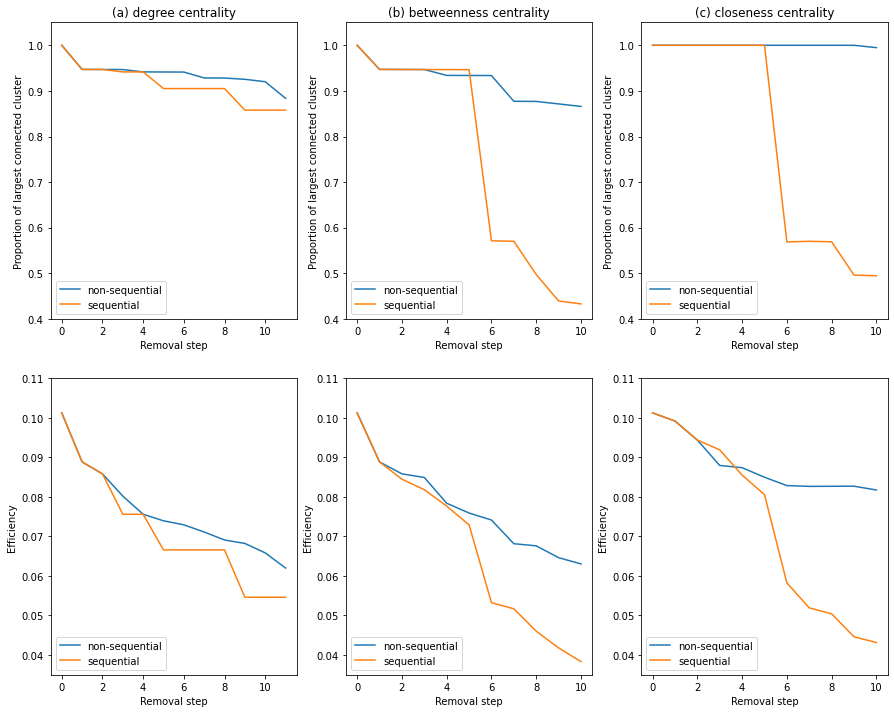

In [38]:
# plot 
fig, axes = plt.subplots(2,3, figsize=(15,12))
for label, df in deg_df.groupby('Removal Strategy'):
    df.plot(ax=axes[0,0], kind = 'line', x="step", y = 'largest_connected_cluster', label = label)
for label, df in deg_df.groupby('Removal Strategy'):
    df.plot(ax=axes[1,0], kind = 'line', x="step", y = 'efficiency', label = label)
for label, df in bet_df.groupby('Removal Strategy'):
    df.plot(ax=axes[0,1], kind = 'line', x="step", y = 'largest_connected_cluster', label = label)
for label, df in bet_df.groupby('Removal Strategy'):
    df.plot(ax=axes[1,1], kind = 'line', x="step", y = 'efficiency', label = label)
for label, df in clos_df.groupby('Removal Strategy'):
    df.plot(ax=axes[0,2], kind = 'line', x="step", y = 'largest_connected_cluster', label = label)
for label, df in clos_df.groupby('Removal Strategy'):
    df.plot(ax=axes[1,2], kind = 'line', x="step", y = 'efficiency', label = label)
axes[0,0].set(ylabel="Proportion of largest connected cluster",xlabel="Removal step")
axes[1,0].set(ylabel="Efficiency",xlabel="Removal step")
axes[0,1].set(ylabel="Proportion of largest connected cluster",xlabel="Removal step")
axes[1,1].set(ylabel="Efficiency",xlabel="Removal step")
axes[0,2].set(ylabel="Proportion of largest connected cluster",xlabel="Removal step")
axes[1,2].set(ylabel="Efficiency",xlabel="Removal step")
axes[0,0].title.set_text('(a) degree centrality')
axes[0,1].title.set_text('(b) betweenness centrality')
axes[0,2].title.set_text('(c) closeness centrality')
axes[0,0].set_ylim([0.4, 1.05])
axes[0,1].set_ylim([0.4, 1.05])
axes[0,2].set_ylim([0.4, 1.05])
axes[1,0].set_ylim([0.035, 0.11])
axes[1,1].set_ylim([0.035, 0.11])
axes[1,2].set_ylim([0.035, 0.11])
axes[0,0].legend(loc="lower left")
axes[0,1].legend(loc="lower left")
axes[0,2].legend(loc="lower left")
axes[1,0].legend(loc="lower left")
axes[1,1].legend(loc="lower left")
axes[1,2].legend(loc="lower left")
plt.savefig("noderemoval.png")

### Section II
#### Question II.1

In [39]:
# create inverse weights
inv_weights={(e1, e2):round(1./flows,7) for e1, e2, flows in G.edges(data='flows')}

# add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(G, inv_weights, 'inv_flows')

In [40]:
# check edge
list(G.edges(data = True))[0]

("Earl's Court",
 'Gloucester Road',
 {'length': 910.1212138490863,
  'line_name': 'District',
  'flows': 83187,
  'inv_flows': 1.2e-05})

In [41]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:
bet_london_w=nx.betweenness_centrality(G,weight='inv_flows',normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_w,'betweenness_w')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))
df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:15]

,betweenness_w
Green Park,42152.00
Bank and Monument,41627.25
Waterloo,32148.00
Westminster,28583.00
Liverpool Street,26879.00
Stratford,26424.00
Euston,21446.50
Oxford Circus,19367.50
Bond Street,19336.00
Baker Street,19007.00


In [42]:
list(G.nodes(data = True))[0]

("Earl's Court",
 {'coords': '(525466.7699525921, 178494.18714144814)',
  'degree': 0.015113350125944584,
  'betweenness_t': 9827.591089466068,
  'closeness_t': 0.09022727272727273,
  'betweenness_w': 17113.0})

#### Question II.2
#### Question II.3

In [43]:
# pre-prep
initial_state_2 = {
    'step': 0,
    'removed_station': 'none',
    'total_flows': G.size(weight="flows"),
    'efficiency':nx.local_efficiency(G)
}
initial_state_list_2 = [initial_state_2]   

In [44]:
# topological - strategy a
# select top 3
bet_london_t_top_3 = [e for e,v in bet_london_sorted[:3]]
bet_london_t_top_3

['Stratford', 'Bank and Monument', 'Liverpool Street']

In [45]:
# create list
bet_t_a_list = []
G_bet_t_a = G.copy()
i=0
for i in range(len(bet_london_t_top_3)):
    G_bet_t_a.remove_nodes_from([bet_london_t_top_3[i]])
    Subg_bet_t_a = [G_bet_a.subgraph(c).copy() for c in nx.connected_components(G_bet_t_a)]
    d = {'step': i+1,
         'removed_station':bet_london_t_top_3[i],
         'total_flows': G_bet_t_a.size(weight='flows')/G.size(weight='flows'),
         'efficiency':nx.global_efficiency(G_bet_t_a)
        }
    bet_t_a_list.append(d)
    G_bet_t_a = G_bet_t_a.copy()

In [46]:
# create the dataframe
bet_t_a_list = initial_state_list_2 + bet_t_a_list
bet_t_a_df = pd.DataFrame(bet_t_a_list)
bet_t_a_df

,step,removed_station,total_flows,efficiency
0,0,none,9.930847e+06,0.030779
1,1,Stratford,9.633513e-01,0.088838
2,2,Bank and Monument,8.930665e-01,0.085826
3,3,Liverpool Street,8.826426e-01,0.084913


In [47]:
# topological - strategy b
bet_t_b_list = []
G_bet_t_b = G.copy()
i = 0
while i < 3:
    bet_london_t=nx.betweenness_centrality(G_bet_t_b, normalized=False)
    nx.set_node_attributes(G_bet_t_b,bet_london_t,'betweenness_t')
    betweenness_t_values=[(k[1]['betweenness_t']) for k in G_bet_t_b.nodes(data=True)]
    maxbet=[n for n in G_bet_t_b.nodes() if G_bet_t_b.nodes[n]['betweenness_t'] == max(betweenness_t_values)]
    G_bet_t_b.remove_nodes_from(maxbet)
    print(maxbet)
    Subg_bet_t_b = [G_bet_t_b.subgraph(c).copy() for c in nx.connected_components(G_bet_t_b)]
    d = {'step': i+1,
         'removed_station':maxbet[0],
         'total_flows': 1-(G_bet_t_b.size(weight='flows')/G.size(weight="flows")),
         'efficiency':nx.global_efficiency(G_bet_t_b)
        }
    bet_t_b_list.append(d)
    G_bet_t_b = G_bet_t_b.copy()
    i += 1


['Stratford']
["King's Cross St. Pancras"]
['Waterloo']


In [48]:
# create the dataframe
bet_t_b_list = initial_state_list_2 + bet_t_b_list
bet_t_b_df = pd.DataFrame(bet_t_b_list)
bet_t_b_df

,step,removed_station,total_flows,efficiency
0,0,none,9.930847e+06,0.030779
1,1,Stratford,3.664874e-02,0.088838
2,2,King's Cross St. Pancras,8.408870e-02,0.084473
3,3,Waterloo,1.395549e-01,0.081822


In [49]:
# weighted - strategy a
# sort the order 
bet_london_w_sorted = sorted(bet_london_w.items(), key=lambda x:x[1], reverse=True)
# select top 10
bet_london_w_top_3 = [e for e,v in bet_london_w_sorted[:3]]

In [50]:
bet_london_w_top_3

['Green Park', 'Bank and Monument', 'Waterloo']

In [51]:
# create list
bet_w_a_list = []
G_bet_w_a = G.copy()
i=0
for i in range(len(bet_london_w_top_3)):
    G_bet_w_a.remove_nodes_from([bet_london_w_top_3[i]])
    Subg_bet_w_a = [G_bet_w_a.subgraph(c).copy() for c in nx.connected_components(G_bet_w_a)]
    d = {'step': i+1,
         'removed_station':bet_london_w_top_3[i],
         'total_flows': G_bet_w_a.size(weight='flows')/G.size(weight="flows"),
         'efficiency':nx.global_efficiency(G_bet_w_a)
        }
    bet_w_a_list.append(d)
    G_bet_w_a = G_bet_w_a.copy()

In [52]:
# create the dataframe
bet_w_a_list = initial_state_list_2 + bet_w_a_list
bet_w_a_df = pd.DataFrame(bet_w_a_list)
bet_w_a_df

,step,removed_station,total_flows,efficiency
0,0,none,9.930847e+06,0.030779
1,1,Green Park,9.418326e-01,0.099189
2,2,Bank and Monument,8.715478e-01,0.094963
3,3,Waterloo,8.418136e-01,0.093536


In [53]:
# weighted - strategy b
bet_w_b_list = []
G_bet_w_b = G.copy()
i = 0
while i < 3:
    bet_london_w=nx.betweenness_centrality(G_bet_w_b, weight='inv_flows', normalized=False)
    nx.set_node_attributes(G_bet_w_b,bet_london_w,'betweenness_w')
    betweenness_w_values=[(k[1]['betweenness_w']) for k in G_bet_w_b.nodes(data=True)]
    maxbet=[n for n in G_bet_w_b.nodes() if G_bet_w_b.nodes[n]['betweenness_w'] == max(betweenness_w_values)]
    G_bet_w_b.remove_nodes_from(maxbet)
    print(maxbet)
    Subg_bet_w_b = [G_bet_w_b.subgraph(c).copy() for c in nx.connected_components(G_bet_w_b)]
    d = {'step': i+1,
         'removed_station':maxbet[0],
         'total_flows': G_bet_w_b.size(weight='flows'),
         'efficiency':nx.global_efficiency(G_bet_w_b)
        }
    bet_w_b_list.append(d)
    G_bet_w_b = G_bet_w_b.copy()
    i += 1

['Green Park']
['Bank and Monument']
["King's Cross St. Pancras"]


In [54]:
# create the dataframe
bet_w_b_list = initial_state_list_2 + bet_w_b_list
bet_w_b_df = pd.DataFrame(bet_w_b_list)
bet_w_b_df

,step,removed_station,total_flows,efficiency
0,0,none,9930847.0,0.030779
1,1,Green Park,9353195.0,0.099189
2,2,Bank and Monument,8655208.0,0.094963
3,3,King's Cross St. Pancras,8184089.0,0.087945


## Part 2
### Section III
#### Question III.1
#### Question III.2

In [55]:
# read in data 
flowdata = pd.read_csv("london_flows.csv")

In [56]:
# causing error - remove battersea park
flowdata = flowdata[flowdata["station_destination"] != "Battersea Park"]
flowdata = flowdata[flowdata["station_origin"] != "Battersea Park"]
flowdata = flowdata[flowdata["distance"] != 0]

In [57]:
# the number of population at the m
flowdata.head(5)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [58]:
# check the number of rows
flowdata.shape

(61413, 6)

In [59]:
# is it poission distribution?
flow_mean = flowdata["flows"].mean()
flow_mean

25.113298487290965

In [60]:
# create distribution 
poissonDis = poisson.rvs(flow_mean, size=61474)

In [61]:
poissonDis

array([24, 27, 26, ..., 27, 25, 27])

In [62]:
# conduct kstest - follows poisson distribution 
kstest(flowdata["flows"], poissonDis)

KstestResult(statistic=0.7525725379160995, pvalue=0.0)

In [63]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    flowdata[f"log_{x}"] = np.log(flowdata[x])
    log_x_vars.append(f"log_{x}")

In [64]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flowdata.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flowdata = flowdata.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flowdata.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flowdata = flowdata.merge(D_j, on = "station_destination", how = "left" )

In [65]:
# check data 
flowdata.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428


In [66]:
# create matrics
flowdata_matrics = flowdata.pivot_table(values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

In [67]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a production constrained sim
prodSim_invpow = smf.glm(formula = formula, data=flowdata, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim_invpow.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Tue, 02 May 2023   Deviance:                   1.8615e+06
Time:                        04:18:42   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [68]:
# pulling out the parameter values
coefs_invpow = pd.DataFrame(prodSim_invpow.params)
coefs_invpow.reset_index(inplace=True)
coefs_invpow.rename(columns = {0:"alpha_i_invpow", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs_invpow["coef"] = coefs_invpow["coef"].str.replace(x, "")

/tmp/ipykernel_726/3254011901.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs_invpow["coef"] = coefs_invpow["coef"].str.replace(x, "")


In [69]:
#then once you have done this you can join them back into the dataframes
flowdata = flowdata.merge(coefs_invpow, left_on="station_origin", right_on="coef", how = "left")
flowdata.drop(columns = ["coef"], inplace = True)
#check this has worked
flowdata.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i_invpow
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242


In [70]:
alpha_i_invpow = prodSim_invpow.params[0:-2]
gamma_invpow = prodSim_invpow.params[-2]
beta_invpow = -prodSim_invpow.params[-1]

In [71]:
alpha_i_invpow

station_origin[Abbey Road]          3.250242
station_origin[Acton Central]       5.016902
station_origin[Acton Town]          4.562892
station_origin[Aldgate]             3.323767
station_origin[Aldgate East]        3.457664
                                      ...   
station_origin[Wood Street]         5.242024
station_origin[Woodford]            5.160643
station_origin[Woodgrange Park]     5.254667
station_origin[Woodside Park]       4.698635
station_origin[Woolwich Arsenal]    6.905590
Length: 398, dtype: float64

In [72]:
gamma_invpow

0.76861562001244

In [73]:
beta_invpow

0.8781191183724274

In [74]:
# produce estimates
flowdata["est_invpow"] = np.exp(flowdata["alpha_i_invpow"]+gamma_invpow*flowdata["log_jobs"] - beta_invpow*flowdata["log_distance"]) 

In [75]:
flowdata

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i_invpow,est_invpow
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242,55.010681
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242,0.986106
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242,2.755640
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242,66.457296
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242,49.060970
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,7892,3342,6.905590,121.206340
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,7892,5487,6.905590,259.262677
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7892,400,6.905590,31.963713
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,7892,893,6.905590,98.359769


In [76]:
#first round the estimates
flowdata["est_invpow"] = round(flowdata["est_invpow"],0)

In [77]:
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flowdata_invpow = flowdata.pivot_table(values ="est_invpow", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flowdata_invpow

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [78]:
# compare with matrics
flowdata_matrics

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [79]:
# calculate Rsquare
CalcRSquared(flowdata["flows"], flowdata["est_invpow"])

0.38827639501786254

In [80]:
# calculate RMSE
CalcRMSE(flowdata["flows"], flowdata["est_invpow"])

102.893

In [81]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula_2 = 'flows ~ station_origin + log_jobs + distance-1'
#run a production constrained sim
prodSim_negexp = smf.glm(formula = formula_2, data=flowdata, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim_negexp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Tue, 02 May 2023   Deviance:                   1.6477e+06
Time:                        04:19:22   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [82]:
#get the predictions
predictions_prod_negexp = prodSim_negexp.get_prediction(flowdata[["station_origin", "log_jobs", "distance"]])
predictions_summary_frame_prod_negexp = predictions_prod_negexp.summary_frame()
flowdata["est_negexp"] = round(predictions_summary_frame_prod_negexp["mean"],0)


In [83]:
#check if it worked
flowdata.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i_invpow,est_invpow,est_negexp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242,55.0,78.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242,3.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242,66.0,99.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242,49.0,56.0


In [84]:
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flowdata_negexp = flowdata.pivot_table(values ="est_negexp", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flowdata_negexp

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [85]:
# compare!
flowdata_matrics

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [86]:
# calculate Rsquare
CalcRSquared(flowdata["flows"], flowdata["est_negexp"])

0.4680648443542886

In [87]:
# calculate RMSE
CalcRMSE(flowdata["flows"], flowdata["est_negexp"])

96.263

### Section IV
#### Question IV.1

In [88]:
# create column with new number of jobs 
cw = (flowdata['station_destination'] == 'Canary Wharf')
flowdata_cw = flowdata[cw]

flowdata["jobs_scenario_a"] = flowdata["jobs"]
flowdata.loc[cw, 'jobs_scenario_a'] = 0.5*flowdata_cw['jobs']

In [89]:
# check data
df_cw = flowdata[flowdata['station_destination'] == 'Canary Wharf']
df_cw

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i_invpow,est_invpow,est_negexp,jobs_scenario_a
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242,66.0,99.0,29386
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,8.228177,10.981421,9.923200,3745,58772,4.562892,73.0,35.0,29386
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,7.967627,10.981421,8.789419,2886,58772,3.323767,57.0,77.0,29386
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,8.062118,10.981421,8.542471,3172,58772,3.457664,81.0,105.0,29386
817,All Saints,Canary Wharf,67,740,58772,1340.088733,6.606650,10.981421,7.200491,740,58772,3.380602,244.0,183.0,29386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60534,Wood Green,Canary Wharf,64,6667,58772,16849.246595,8.804925,10.981421,9.732061,6667,58772,5.137983,153.0,105.0,29386
60777,Wood Lane,Canary Wharf,0,1088,58772,17092.091760,6.992096,10.981421,9.746371,1088,58772,3.154679,21.0,12.0,29386
61001,Woodford,Canary Wharf,192,4868,58772,13963.787075,8.490438,10.981421,9.544223,4868,58772,5.160643,185.0,250.0,29386
61233,Woodside Park,Canary Wharf,42,3093,58772,22356.567178,8.036897,10.981421,10.014875,3093,58772,4.698635,77.0,41.0,29386


In [90]:
alpha_i_negexp = prodSim_negexp.params[0:-2]
gamma_negexp = prodSim_negexp.params[-2]
beta_negexp = -prodSim_negexp.params[-1]

In [91]:
beta_negexp

0.00015316619346317185

In [92]:
# calculate check
#calculate some new wj^alpha and d_ij^beta values
gamma_check = flowdata["jobs"]**gamma_negexp
beta_check = np.exp((-beta_negexp)*flowdata["distance"])
#calculate the first stage of the Ai values
flowdata["Ai_check"] = gamma_check * beta_check
#now do the sum over all js bit
Ai_check = pd.DataFrame(flowdata.groupby(["station_origin"])["Ai_check"].agg(np.sum))
Ai_check.rename(columns={"Ai_check": "Ai_check_sum"}, inplace = True)
#now divide into 1
Ai_check["Ai_check_inv"] = 1/Ai_check["Ai_check_sum"]

In [93]:
Ai_check

,Ai_check_sum,Ai_check_inv
station_origin,,
Abbey Road,11043.347567,0.000091
Acton Central,3912.653095,0.000256
Acton Town,18793.343418,0.000053
Aldgate,54757.741343,0.000018
Aldgate East,55098.053442,0.000018
...,...,...
Wood Street,3508.677696,0.000285
Woodford,9173.220150,0.000109
Woodgrange Park,1298.933512,0.000770


In [94]:
#and write the A_i values back into the dataframe
flowdata = flowdata.merge(Ai_check, left_on="station_origin", right_index=True, how="left")

In [95]:
# check data
flowdata

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i_invpow,est_invpow,est_negexp,jobs_scenario_a,Ai_check,Ai_check_sum,Ai_check_inv
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242,55.0,78.0,78549,1432.231104,11043.347567,0.000091
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242,1.0,1.0,442,27.026714,11043.347567,0.000091
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242,3.0,4.0,665,75.982904,11043.347567,0.000091
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242,66.0,99.0,29386,1834.127323,11043.347567,0.000091
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242,49.0,56.0,15428,1034.750388,11043.347567,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,7892,3342,6.905590,121.0,99.0,3342,58.874685,4701.156213,0.000213
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,7892,5487,6.905590,259.0,295.0,5487,175.878367,4701.156213,0.000213
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7892,400,6.905590,32.0,36.0,400,21.416897,4701.156213,0.000213
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,7892,893,6.905590,98.0,125.0,893,74.528041,4701.156213,0.000213


In [96]:
#to check everything works, recreate the original estimates - standard model
flowdata["est_check"] = flowdata["Ai_check_inv"]*flowdata["O_i"]*gamma_check*beta_check
#round
flowdata["est_check"] = round(flowdata["est_check"])
#check
flowdata[["est_negexp", "est_check"]]

,est_negexp,est_check
0,78.0,78.0
1,1.0,1.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0
...,...,...
61408,99.0,99.0
61409,295.0,295.0
61410,36.0,36.0
61411,125.0,125.0


In [97]:
# compute for scenario a
gamma_sc_a = flowdata["jobs_scenario_a"]**gamma_negexp
#calcualte the first stage of the Ai values
flowdata["Ai_sc_a"] = gamma_sc_a * beta_check
#now do the sum over all js bit
Sc_a = pd.DataFrame(flowdata.groupby(["station_origin"])["Ai_sc_a"].agg(np.sum))
#now divide into 1
Sc_a["Ai_sc_a_inv"] = 1/Sc_a["Ai_sc_a"]
Sc_a.rename(columns={"Ai_sc_a":"Ai_sc_a_sum"}, inplace=True)
#and write the A_i values back into the dataframe
flowdata = flowdata.merge(Sc_a, left_on="station_origin", right_index=True, how="left")

In [98]:
# check
flowdata.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,...,est_invpow,est_negexp,jobs_scenario_a,Ai_check,Ai_check_sum,Ai_check_inv,est_check,Ai_sc_a,Ai_sc_a_sum,Ai_sc_a_inv
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,...,55.0,78.0,78549,1432.231104,11043.347567,0.000091,78.0,1432.231104,10295.858846,0.000097
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,...,1.0,1.0,442,27.026714,11043.347567,0.000091,1.0,27.026714,10295.858846,0.000097
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,...,3.0,4.0,665,75.982904,11043.347567,0.000091,4.0,75.982904,10295.858846,0.000097
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,...,66.0,99.0,29386,1834.127323,11043.347567,0.000091,99.0,1086.638601,10295.858846,0.000097
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,...,49.0,56.0,15428,1034.750388,11043.347567,0.000091,56.0,1034.750388,10295.858846,0.000097


In [99]:
#to check everything works, recreate the original estimates - standard model
flowdata["est_sc_a"] = flowdata["Ai_sc_a_inv"]*flowdata["O_i"]*gamma_sc_a*beta_check
#round
flowdata["est_sc_a"] = round(flowdata["est_sc_a"])

flowdata_sc_a = flowdata.pivot_table(values ="est_sc_a", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flowdata_sc_a

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [100]:
# compare
flowdata_negexp

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [101]:
# compare 
flowdata_matrics


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [105]:
cw_normal = flowdata_matrics.loc['All','Canary Wharf']
cw_normal

58772.0

In [106]:
cw_sc_a = flowdata_sc_a.loc['All','Canary Wharf']
cw_sc_a

29489.0

In [134]:
flowdata_sc_a_change = flowdata_sc_a - flowdata_matrics

In [135]:
flowdata_sc_a_change

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-24.0,-2.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0
Acton Town,NaN,NaN,NaN,10.0,-4.0,NaN,-21.0,0.0,NaN,5.0,...,-64.0,0.0,-4.0,11.0,NaN,0.0,NaN,1.0,NaN,5.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,11.0,...,2.0,NaN,-1.0,-6.0,NaN,1.0,NaN,1.0,NaN,0.0
Aldgate East,NaN,NaN,-1.0,41.0,NaN,NaN,0.0,0.0,NaN,9.0,...,-22.0,0.0,3.0,-10.0,NaN,0.0,NaN,0.0,NaN,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,-1.0,37.0,6.0,NaN,NaN,NaN,NaN,9.0,...,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,-8.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
Woodside Park,NaN,NaN,1.0,-7.0,8.0,NaN,0.0,NaN,NaN,-27.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0


In [109]:
flowdata_change_sc_a_prop = flowdata_sc_a_change/flowdata_matrics

In [110]:
flowdata_change_sc_a_prop

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.75000,-0.003339
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001634
Acton Town,NaN,NaN,NaN,3.333333,-0.235294,NaN,-0.600000,NaN,NaN,0.454545,...,-0.831169,0.000000,-0.666667,1.222222,NaN,NaN,NaN,inf,NaN,0.001335
Aldgate,NaN,NaN,inf,NaN,inf,NaN,NaN,NaN,NaN,0.647059,...,inf,NaN,-0.250000,-0.750000,NaN,inf,NaN,inf,NaN,0.000000
Aldgate East,NaN,NaN,-0.500000,inf,NaN,NaN,NaN,NaN,NaN,0.450000,...,-0.916667,NaN,inf,-0.833333,NaN,0.000000,NaN,0.000000,NaN,-0.001576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,-0.500000,7.400000,0.127660,NaN,NaN,NaN,NaN,0.409091,...,0.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.001643
Woodgrange Park,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003774
Woodside Park,NaN,NaN,1.000000,-0.269231,0.727273,NaN,NaN,NaN,NaN,-0.457627,...,inf,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,0.002910


In [156]:
flowdata_mat_cw = pd.DataFrame(flowdata_change_sc_a_prop["Canary Wharf"])
flowdata_mat_cw.dropna(inplace = True)
flowdata_mat_cw.sort_values(by='Canary Wharf', inplace = True) 

In [160]:
flowdata_mat_cw.head(20)

,Canary Wharf
station_origin,
Southwark,-0.952414
Amersham,-0.944444
Bond Street,-0.940559
St. John's Wood,-0.937824
Westminster,-0.933852
Swiss Cottage,-0.930939
Stanmore,-0.927885
Chalfont & Latimer,-0.921053
Green Park,-0.921053


In [145]:
flowdata_sc_a_change_cw = pd.DataFrame(flowdata_sc_a_change["Canary Wharf"])
flowdata_sc_a_change_cw.dropna(inplace = True)

In [146]:
flowdata_sc_a_change_cw_sorted = flowdata_sc_a_change_cw.sort_values(by='Canary Wharf')

In [152]:
flowdata_sc_a_change_cw_sorted.tail(10)

,Canary Wharf
station_origin,
London City Airport,213.0
East India,221.0
South Quay,250.0
Barking,253.0
Whitechapel,292.0
Heron Quays,320.0
Poplar,323.0
Westferry,336.0
Liverpool Street,485.0


In [154]:
flowdata_sc_a_change_cw_sorted.head(10)

,Canary Wharf
station_origin,
All,-29283.0
Waterloo,-7249.0
London Bridge,-5612.0
Canada Water,-3044.0
Stratford,-2059.0
Bank and Monument,-1844.0
Southwark,-1361.0
North Greenwich,-911.0
Bermondsey,-783.0


#### Question IV.2

In [102]:
# calculate check
#calculate some new wj^alpha and d_ij^beta values
gamma_check = flowdata["jobs"]**gamma_negexp
beta_sc_b1 = np.exp((-beta_negexp)*10*flowdata["distance"])
#calculate the first stage of the Ai values
flowdata["Ai_sc_b1"] = gamma_check * beta_sc_b1
#now do the sum over all js bit
Ai_sc_b1 = pd.DataFrame(flowdata.groupby(["station_origin"])["Ai_sc_b1"].agg(np.sum))
Ai_sc_b1.rename(columns={"Ai_sc_b1": "Ai_sc_b1_sum"}, inplace = True)
#now divide into 1
Ai_sc_b1["Ai_sc_b1_inv"] = 1/Ai_sc_b1["Ai_sc_b1_sum"]

In [127]:
#and write the A_i values back into the dataframe
flowdata = flowdata.merge(Ai_sc_b1, left_on="station_origin", right_index=True, how="left")

In [128]:
#to check everything works, recreate the original estimates - standard model
flowdata["est_sc_b1"] = flowdata["Ai_sc_b1_inv"]*flowdata["O_i"]*gamma_check*beta_sc_b1
#round
flowdata["est_sc_b1"] = round(flowdata["est_sc_b1"])

flowdata_sc_b1 = flowdata.pivot_table(values ="est_sc_b1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flowdata_sc_b1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,2.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,NaN,0.0,NaN,0.0,NaN,3742.0
Aldgate,NaN,NaN,0.0,NaN,87.0,NaN,NaN,0.0,NaN,4.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2881.0
Aldgate East,NaN,NaN,0.0,117.0,NaN,NaN,0.0,0.0,NaN,3.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [129]:
# calculate check
#calculate some new wj^alpha and d_ij^beta values
gamma_check = flowdata["jobs"]**gamma_negexp
beta_sc_b2 = np.exp((-beta_negexp)*1000*flowdata["distance"])
#calculate the first stage of the Ai values
flowdata["Ai_sc_b2"] = gamma_check * beta_sc_b2
#now do the sum over all js bit
Ai_sc_b2 = pd.DataFrame(flowdata.groupby(["station_origin"])["Ai_sc_b2"].agg(np.sum))
Ai_sc_b2.rename(columns={"Ai_sc_b2": "Ai_sc_b2_sum"}, inplace = True)
#now divide into 1
Ai_sc_b2["Ai_sc_b2_inv"] = 1/Ai_sc_b2["Ai_sc_b2_sum"]

In [130]:
#and write the A_i values back into the dataframe
flowdata = flowdata.merge(Ai_sc_b2, left_on="station_origin", right_index=True, how="left")

In [131]:
#to check everything works, recreate the original estimates - standard model
flowdata["est_sc_b2"] = flowdata["Ai_sc_b2_inv"]*flowdata["O_i"]*gamma_check*beta_sc_b2
#round
flowdata["est_sc_b2"] = round(flowdata["est_sc_b2"])

flowdata_sc_b2 = flowdata.pivot_table(values ="est_sc_b2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flowdata_sc_b2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3745.0
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2886.0
Aldgate East,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


#### Question IV.3

In [193]:
# scenario a
# calculate 
sc_a_change = flowdata_sc_a - flowdata_matrics

In [194]:
# extract total flow for destinations 
sc_a_change = pd.DataFrame(sc_a_change.loc['All',])

In [195]:
# calculate squared value
sc_a_change["dif_sq"] = sc_a_change["All"]**2

In [196]:
sc_a_change

,All,dif_sq
station_destination,,
Abbey Road,66.0,4356.0
Acton Central,-391.0,152881.0
Acton Town,-30.0,900.0
Aldgate,856.0,732736.0
Aldgate East,1680.0,2822400.0
...,...,...
Woodford,-33.0,1089.0
Woodgrange Park,-82.0,6724.0
Woodside Park,-318.0,101124.0


In [198]:
# calculate mean 
sc_a_change["dif_sq"].mean()

3890986.7568922304

In [184]:
# scenario b1
# calculate 
sc_b1_change = flowdata_sc_b1 - flowdata_matrics

In [185]:
# extract total flow for destinations 
sc_b1_change = pd.DataFrame(sc_b1_change.loc['All',])

In [189]:
# calculate squared value
sc_b1_change["dif_sq"] = sc_b1_change["All"]**2

In [190]:
# drop all column 
sc_b1_change.drop(["All"],inplace=True)

In [192]:
# calculate mean 
sc_b1_change["dif_sq"].mean()

27017455.8040201

In [191]:
sc_b1_change

,All,dif_sq
station_destination,,
Abbey Road,3144.0,9884736.0
Acton Central,-416.0,173056.0
Acton Town,2052.0,4210704.0
Aldgate,-2948.0,8690704.0
Aldgate East,-2151.0,4626801.0
...,...,...
Wood Street,3847.0,14799409.0
Woodford,1778.0,3161284.0
Woodgrange Park,496.0,246016.0


In [177]:
# scenario b2
# calculate 
sc_b2_change = flowdata_sc_b2 - flowdata_matrics

In [178]:
# extract total flow for destinations 
sc_b2_change = pd.DataFrame(sc_b2_change.loc['All',])

In [179]:
# calculate squared value
sc_b2_change["dif_sq"] = sc_b2_change["All"]**2

In [181]:
# drop all column 
sc_b2_change.drop(["All"],inplace=True)

In [183]:
# calculate mean 
sc_b2_change["dif_sq"].mean()

112332491.41708542

In [182]:
sc_b2_change

,All,dif_sq
station_destination,,
Abbey Road,8534.0,72829156.0
Acton Central,-750.0,562500.0
Acton Town,-2202.0,4848804.0
Aldgate,719.0,516961.0
Aldgate East,4349.0,18913801.0
...,...,...
Wood Street,2537.0,6436369.0
Woodford,-299.0,89401.0
Woodgrange Park,521.0,271441.0


In [203]:
print(len(flowdata[flowdata["flows"] == 0]))
print(len(flowdata[flowdata["est_sc_a"] == 0]))
print(len(flowdata[flowdata["est_sc_b1"] == 0]))
print(len(flowdata[flowdata["est_sc_b2"] == 0]))

17468
8939
53609
60855
